In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keras tqdm                                                                                                                                                                                                                                                                                                        

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install ipywidgets

In [1]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import random

In [2]:
import numpy as np
def load_image(img_file, target_size=(224,224)):
    X = np.zeros((1, *target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file, 
        target_size=target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

import os
def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

In [3]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

17235968/17225924 [==============================] - 2s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32

In [4]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
print(f'shape: {dog_image.shape}')
print(f'type: {type(dog_image)}')
model.predict(dog_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[2.91943558e-09, 1.58655522e-09, 1.33307667e-08, 1.75802328e-09,
        2.59459600e-08, 8.89992136e-10, 1.79754212e-09, 4.53371598e-08,
        2.05828066e-08, 2.58487148e-07, 9.59659108e-09, 1.47970747e-08,
        8.04519917e-09, 4.00610478e-09, 6.36610054e-08, 3.06020311e-08,
        2.27669616e-09, 4.08688351e-07, 2.76322822e-07, 2.75226224e-08,
        4.71726658e-09, 5.44544010e-09, 6.38795072e-10, 9.33441515e-06,
        5.71588487e-07, 8.24187740e-09, 1.99433394e-08, 2.01779173e-07,
        5.15417682e-08, 1.13096121e-09, 1.18210419e-08, 8.27375679e-09,
        9.96158489e-10, 2.22971086e-10, 1.13973364e-09, 1.05924132e-08,
        2.50874987e-09, 1.79816961e-09, 1.19515533e-07, 1.83981498e-07,
        4.87247576e-07, 5.59000597e-08, 5.12613951e-07, 2.78857968e-08,
        4.14900256e-07, 3.29427792e-08, 1.19885755e-07, 6.37413109e-08,
        4.72079989e-07, 1.08896385e-08, 2.46354759e-08, 2.29049597e-08,
        4.92080474e-08, 2.04461031e-07, 7.37451629e-08, 5.601241

In [5]:
model = tf.keras.applications.mobilenet.MobileNet(
# The 3 is the three dimensions of the input: r,g,b.
  input_shape=(224, 224, 3), 
  include_top=False, 
  pooling='avg'
)

17235968/17225924 [==============================] - 1s 0us/step


In [6]:
dog_image_id = os.listdir('images/dog')[0]
dog_image = load_image(os.path.join('images/dog',dog_image_id))
model.predict(dog_image).shape

(1, 1024)

In [7]:
x = Dropout(rate=0.4)(model.output)
# This determines the number of outputs, and thus the number of categories, in my test case 2: dog or cat
x = Dense(2)(x)
x = Softmax()(x)
model= Model(model.inputs, x) 

In [8]:
for layer in model.layers[:-3]:
    layer.trainable = False

In [9]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy'
)

In [10]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=_mobilenet.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

ensure_folder_exists('training_aug')
training = datagen.flow_from_directory( 
    './images', 
    target_size=(224, 224),
    save_to_dir='./training_aug',
    subset='training'
) 

ensure_folder_exists('validation_aug')
validation = datagen.flow_from_directory( 
    './images',
    target_size=(224, 224),
    save_to_dir='./validation_aug',
    subset='validation'
) 

Found 94 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


In [11]:
batch_size = 32

history = model.fit(
    x=training,
    steps_per_epoch=training.samples // batch_size,
    epochs=10,
    validation_data=validation,
    validation_steps=validation.samples // batch_size
)

Epoch 1/10
2/2 [==============================] - 3s 1s/step - loss: 1.1172
Epoch 2/10
2/2 [==============================] - 2s 1s/step - loss: 0.4590
Epoch 3/10
2/2 [==============================] - 2s 756ms/step - loss: 0.3737
Epoch 4/10
2/2 [==============================] - 2s 1s/step - loss: 0.4302
Epoch 5/10
2/2 [==============================] - 2s 962ms/step - loss: 0.4623
Epoch 6/10
2/2 [==============================] - 2s 1s/step - loss: 0.2768
Epoch 7/10
2/2 [==============================] - 2s 1s/step - loss: 0.3323
Epoch 8/10
2/2 [==============================] - 2s 1s/step - loss: 0.2966
Epoch 9/10
2/2 [==============================] - 2s 944ms/step - loss: 0.4033
Epoch 10/10
2/2 [==============================] - 2s 1s/step - loss: 0.2252


KeyError: 'val_loss'

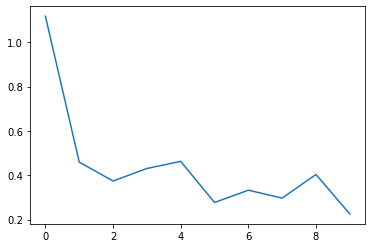

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
random_cat = random.choice(os.listdir('images/cat/'))
cat_path = os.path.join('images/cat',random_cat)
cat = load_image(cat_path)
random_dog = random.choice(os.listdir('images/dog/'))
dog_path = os.path.join('images/dog',random_dog)
dog = load_image(dog_path)

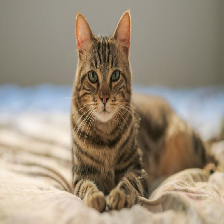

In [15]:
tf.keras.preprocessing.image.load_img(cat_path, target_size=(224,224))

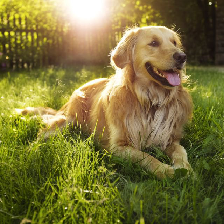

In [16]:
tf.keras.preprocessing.image.load_img(dog_path, target_size=(224,224))

In [17]:
print(f'''cat:{np.round(model.predict(cat),2)}''')

cat:[[1. 0.]]


In [23]:
print(f'''dog:{np.round(model.predict(dog),2)}''')

dog:[[0.99 0.01]]


In [36]:
tiger_path = 'tiger.jpg'
tiger = load_image(tiger_path)

FileNotFoundError: [Errno 2] No such file or directory: 'tiger.jpg'

In [28]:
tf.keras.preprocessing.image.load_img(tiger_path, target_size=(224,224))

FileNotFoundError: [Errno 2] No such file or directory: 'tiger.jpg'

In [29]:
print(f'''tiger:{np.round(model.predict(tiger),2)}''')

NameError: name 'tiger' is not defined